In [1]:
import tensorflow as tf
from tensorflow.keras import Model
import nodepy.linear_multistep_method as lm
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import timeit

# 1. Training

Here we test the problem on the 2-D Cubic Harmonic Oscillator

$$ \begin{array}
\dot{x_1} & = & -0.1 x_1^3 + 2.0 x_2^3 \\
\dot{x_2} & = & -2.0 x_1^3 - 0.1 x_2^3 \\
\end{array} $$

with the initial conditions $x_1(0) = 2, x_2(0) = 0$.

In [2]:
def f(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

Now we are ready to create the training dataset by integrating the above system of equations to obtain the measurements. We also introduce a Gaussian noise to the dataset.

In [3]:
# create time points
time_points = np.arange(0,25,0.01)

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

In [4]:
# create training data

noise = 0.00 #strength of the noise

skip = 1
dt = time_points[skip] - time_points[0]
X_train = simulated_x[0::skip,:]
X_train = X_train + noise * X_train.std(0) * np.random.randn(X_train.shape[0], X_train.shape[1])

X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))

Now we implement the LMMNet. From preliminary experiments, it seems that 10,000 epochs are sufficient to get a loss that more or less converges.

In [4]:
%%writefile lmmNet.py

class lmmNet:
    """
    Implementation of the LMMNet
    version 1
    Fixes/updates:
        * fixed bug for wrong indexing of the coefficients in computing linear diff operator
        * loss printed every 100 epochs
        * optimizer now declared in constructor
        * fixed logical error in the computation of linear difference operator
    """
    
    def __init__(self, h, X, M, scheme):
        """
        Args:
        * step size h
        * data array X with shape S x N x D 
        * M number of LMM steps
        
        """
        self.h = h
        self.X = X
        self.M = M # number of time steps
        
        # get the number of trajectories, discrete time instances, and number of feature dimensions
        self.S = X.shape[0]
        self.N = X.shape[1]
        self.D = X.shape[2]
        
        # load LMM coefficients from NodePy
        # https://nodepy.readthedocs.io/en/latest/
        if scheme == 'AB':
            coefs = lm.Adams_Bashforth(M)
        elif scheme == 'AM':
            coefs = lm.Adams_Moulton(M)
        elif scheme == 'BDF':
            coefs = lm.backward_difference_formula(M)
        else:
            raise Exception('Please choose a valid LMM scheme')
        
        self.alpha = np.float32(-coefs.alpha[::-1])
        self.beta = np.float32(coefs.beta[::-1])
        
        class DenseModel(Model):
            """
            A simple feed-forward network with 1 hidden layer
            
            Arch:
            * 256 hidden units
            * input units and output units correspond to the dimensionality
            """
            def __init__(self, D):
                super(DenseModel, self).__init__()
                self.D = D

                self.d1 = tf.keras.layers.Dense(units=256, activation=tf.nn.tanh, input_shape=(self.D,))
                self.d2 = tf.keras.layers.Dense(units=self.D, activation=None)

            def call(self, X1):
                A = self.d1(X1)
                A = self.d2(A)
                return A
        
        self.nn = DenseModel(self.D)
                
        self.opt = tf.keras.optimizers.Adam()
        
    def get_F(self, X):
        """
        Output of the NN/ML model.
        
        Args:
        - X: the data matrix with shape S x (N-M) x D
        
        Output:
        - F: the output dynamics with shape S x (N-M) x D
        """

        assert X.shape == (self.S, self.N - self.M, self.D)
        
        X1 = tf.reshape(X, [-1, self.D])
        F1 = self.nn(X1)
        
        return tf.reshape(F1, [self.S, -1, self.D])
    
    def get_Y(self, X):
        """
        The linear difference (residual) operator.
        
        Args:
        - X: the data matrix with shape S x N x D
        """
        
        M = self.M
        
        # compute the difference operator
        # broadcasting from M to N to get an array for all n
        # Y has shape S x (N - M) x D
        Y = self.alpha[0] * X[:, M: ,:] + self.h * self.beta[0] * self.get_F(X[:, M:, :]) # for m = 0
        
        # sum over m from m = 1
        for m in range(1, M+1):
            Y += self.alpha[m] * X[:, M-m:-m, :] + self.h * self.beta[m] * self.get_F(X[:, M-m:-m, :])
        
        return self.D * tf.reduce_mean(tf.square(Y))
    
    def train(self, epochs):
        """
        Fit the model PyTorch-style
        """
        
        start_time = timeit.default_timer()
        
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                self.loss = self.get_Y(self.X)
            grads = tape.gradient(self.loss, self.nn.trainable_variables)
            self.opt.apply_gradients(zip(grads, self.nn.trainable_variables))
            
            if epoch % 100 == 0:
                elapsed_time = timeit.default_timer() - start_time
                print('Epoch: %d, Loss: %.3e, Time: %.2f' %(epoch, self.loss, elapsed_time))

        
    def predict(self, X_reshaped):
        """
        Args:
        - X_reshaped with shape S(N-M+1) x D
        """
        return self.nn(X_reshaped)

Overwriting lmmNet.py


In [6]:
X_train.shape

(1, 2500, 2)

In [7]:
# training
#layers = [2, 256, 2]

M = 1
scheme = 'AM'
model = lmmNet(dt, X_train, M, scheme)

N_Iter = 10000
model.train(N_Iter)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 6.992e-04, Time: 0.15
Epoch: 100, Loss: 2.814e-04, Time: 6.77
Epoch: 200, Loss: 2.807e-04, Time: 13.63
Epoch: 300, Loss: 2.801e-04, Time: 20.66
Epoch: 400, Loss: 2.795e-04, Time: 27.34
Epoch: 500, Loss: 2.790e-04, Time: 33.16
Epoch: 600, Loss: 2.785e-04, Time: 39.11
Epoch: 700, Loss: 2.780e-04, Time: 44.98
Epoch: 800, Loss: 2.775e-04, Time: 52.21
Epoch: 900, Loss: 2.769e-04, Time: 58.76
Epoch: 1000, Loss: 2.763e-04, Time: 65.72
Epoch: 1100, Loss: 2.754e-04, Time: 72.30
Epoch: 1200, Loss:

In [8]:
def ml_f(x):
    """
    Define the derivatives (RHS of the ODE) learned by ML
    I think this is the best implementation (more robust than flatten())
    """
    return np.ravel(model.predict(x.reshape(1,-1)))
    
predicted_traj = odeint(lambda x, t: ml_f(x), x0, time_points)

In [9]:
with open('test_pred.npy', 'wb') as file:
    np.save(file, predicted_traj)

predicted_traj

array([[ 2.        ,  0.        ],
       [ 1.99198048, -0.15857564],
       [ 1.98394844, -0.31540016],
       ...,
       [-0.44009291, -0.29348453],
       [-0.44046223, -0.29170874],
       [-0.44082252, -0.28992919]])

# 2. Validation

You may need to terminate kernel to run the codes below. There are OpenMP issues with TensorFlow 2.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

time_points = np.arange(0,25,0.01)
with open('test_pred.npy', 'rb') as file:
    test_pred = np.load(file)

def f(x,t):
    """
    Return the derivatives (RHS of the ODE)
    This is a linear system with the form f = A x
    Args:
    x -- a 2 x 1 vector of measurements
    """
    A = np.array([[-0.1, 2], [-2,-0.1]]) # 2 x 2

    return np.ravel(np.matmul(A,x.reshape(-1, 1)**3))

# create time points
time_points = np.arange(0,25,0.01)

# specify initial conditions
x0 = np.array([2,0])

simulated_x = odeint(f, x0, time_points)

Text(0.5, 1.0, 'Trajectories of 2D Cubic Harmonic Oscillator')

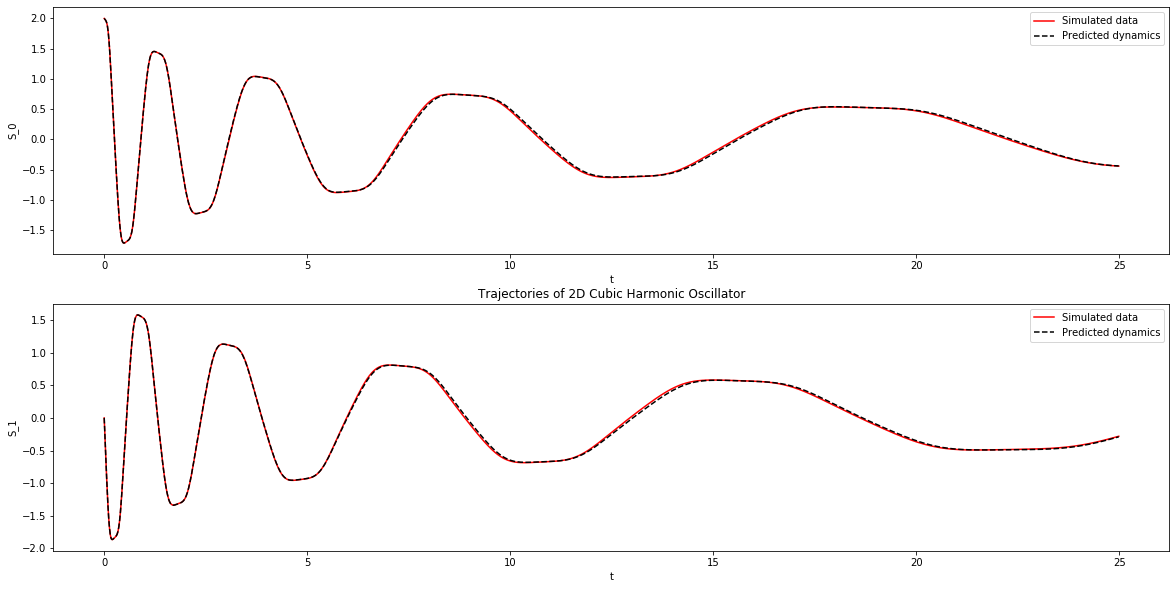

In [2]:

plt.figure(figsize=(20, 10))

for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, simulated_x[:, species], 'r-', label='Simulated data')
    plt.plot(time_points, test_pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Cubic Harmonic Oscillator')

Text(0.5, 1.0, 'Phase plane of 2D Cubic Harmonic Oscillator')

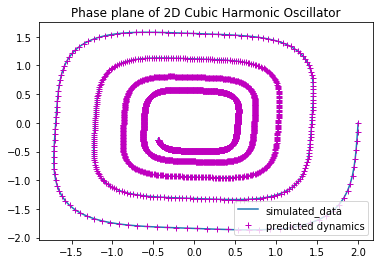

In [3]:
# Phase plane

plt.plot(simulated_x[:,0], simulated_x[:,1], label='simulated_data')
plt.legend()
plt.plot(test_pred[:,0], test_pred[:,1], 'm+', label='predicted dynamics')
plt.legend()
plt.title('Phase plane of 2D Cubic Harmonic Oscillator')